<a href="https://colab.research.google.com/github/Saaia03/pr_1/blob/main/%D0%9B%D0%B0%D0%B1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# загрузка набора данных
df = pd.read_csv('/content/diamond.csv')

# определение соответствий для замены Symmetry
symmetry_mapping = {'EX': 1, 'ID': 2, 'VG': 3, 'G': 4}

# замена Symmetry
df['Symmetry'] = df['Symmetry'].replace(symmetry_mapping)

# определение соответствий для замены Clarity
clarity_mapping = {'FL': 10, 'IF': 20, 'VVS1': 30, 'VVS2': 40, 'VS1': 50, 'VS2':60, 'SI1':70}

# замена Clarity
df['Clarity'] = df['Clarity'].replace(clarity_mapping)

# определение соответствий для замены Cut
cut_mapping = {'Fair': 20, 'Good': 40, 'Very Good': 60, 'Ideal': 80, 'Signature-Ideal': 100}

# замена Cut
df['Cut'] = df['Cut'].replace(cut_mapping)

# определение соответствий для замены Color
color_mapping = {'D': 1, 'E': 2, 'F': 3, 'G': 4, 'H': 5, 'I': 6}

# замена Color
df['Color'] = df['Color'].replace(color_mapping)

# определение соответствий для замены Polish
polish_mapping = {'EX': 1, 'ID': 2, 'VG': 3, 'G': 4}

# замена Polish
df['Polish'] = df['Polish'].replace(polish_mapping)

df['best_diamond'] = np.where(df['Price'] >= 20000 , 1, 0)
df.best_diamond = df.best_diamond.astype('category')
df['Report'] = df['Report'].astype('category')

y = df['best_diamond'] # выбираем целевую переменную (категориальную)
X = df.drop('best_diamond', axis=1) # переменные для проверки влияния

# в моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('Price', axis=1)
df.drop('Price', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Carat Weight  6000 non-null   float64 
 1   Cut           6000 non-null   int64   
 2   Color         6000 non-null   int64   
 3   Clarity       6000 non-null   int64   
 4   Polish        6000 non-null   int64   
 5   Symmetry      6000 non-null   int64   
 6   Report        6000 non-null   category
 7   best_diamond  6000 non-null   category
dtypes: category(2), float64(1), int64(5)
memory usage: 293.3 KB


<ipython-input-7-15aea808e6eb>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Symmetry'] = df['Symmetry'].replace(symmetry_mapping)
<ipython-input-7-15aea808e6eb>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Clarity'] = df['Clarity'].replace(clarity_mapping)
<ipython-input-7-15aea808e6eb>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.

In [8]:
# создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

In [9]:
y.value_counts()

,count
best_diamond,
0,4987
1,1013


In [10]:
# создадим новую целевую переменную y_disbalanced, где 90% классов будут 0, а 10% — 1
from sklearn.utils import resample

# объединяем X и y для удобства
data = pd.concat([X, y], axis=1)

# разделяем на классы
majority = data[data['best_diamond'] == 0]
minority = data[data['best_diamond'] == 1]

# уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# новые X и y
X_disbalanced = data_disbalanced.drop('best_diamond', axis=1)
y_disbalanced = data_disbalanced['best_diamond']

In [11]:
# проверим новый баланс классов:
print(y_disbalanced.value_counts())

best_diamond
0    4987
1     498
Name: count, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

# обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# предсказания
y_pred = model.predict(X_test)

In [13]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9708383961117861

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1498
           1       0.90      0.76      0.82       148

    accuracy                           0.97      1646
   macro avg       0.94      0.88      0.90      1646
weighted avg       0.97      0.97      0.97      1646



In [14]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настолько, что не может предсказать 1

{0: 1520, 1: 126}

In [15]:
# уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                replace=True,
                                n_samples=len(minority),
                                random_state=42)

# объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# новые X и y
X_balanced = data_balanced.drop('best_diamond', axis=1)
y_balanced = data_balanced['best_diamond']

In [16]:
print(y_balanced.value_counts())

best_diamond
0    1013
1    1013
Name: count, dtype: int64


In [17]:
# разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [18]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.9703947368421053

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       315
           1       0.94      1.00      0.97       293

    accuracy                           0.97       608
   macro avg       0.97      0.97      0.97       608
weighted avg       0.97      0.97      0.97       608



Точность высокая для обеих классов. Полнота то же самое. F1-Score = 0,97, что свидетельствует о хорошей сбалансированности между нижней и полнотой.

In [19]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 299, 1: 309}

In [20]:
# выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['float64']).columns.tolist()

# инициализируем scaler
scaler = MinMaxScaler()

# применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

In [21]:
# разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [22]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal)) # Дополнительно получили 1.57% точности, отлично!

Accuracy: 0.9654605263157895

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97       315
           1       0.94      1.00      0.97       293

    accuracy                           0.97       608
   macro avg       0.97      0.97      0.97       608
weighted avg       0.97      0.97      0.97       608



In [23]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 296, 1: 312}

In [24]:
# разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

In [26]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       315
           1       0.94      1.00      0.97       293

    accuracy                           0.97       608
   macro avg       0.97      0.97      0.97       608
weighted avg       0.97      0.97      0.97       608



In [27]:
conf_matrix # матрица
# TN FP
# FN TP

array([[295,  20],
       [  1, 292]])

In [28]:
rounded_items

{'True Negatives (TN)': 295,
 'False Positives (FP)': 20,
 'False Negatives (FN)': 1,
 'True Positives (TP)': 292,
 'Accuracy': 0.97,
 'Precision': 0.94,
 'Recall': 1.0,
 'F1-score': 0.97,
 'ROC-AUC': 0.97}

In [29]:
y = df['Price']

X = df.drop(['Price', 'best_diamond'], axis=1)

In [30]:
# создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

In [31]:
X

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report_GIA
0,1.10,80,5,70,3,1,True
1,0.83,80,5,50,2,2,False
2,0.85,80,5,70,1,1,True
3,0.91,80,2,70,3,3,True
4,0.83,80,4,70,1,1,True
...,...,...,...,...,...,...,...
5995,1.03,80,1,70,1,1,True
5996,1.00,60,1,70,3,3,True
5997,1.02,80,1,70,1,1,True
5998,1.27,100,4,50,1,1,True


In [32]:
from sklearn.tree import DecisionTreeClassifier
# разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [33]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

        2241       0.00      0.00      0.00         0
        2348       0.00      0.00      0.00         1
        2383       0.00      0.00      0.00         0
        2396       0.00      0.00      0.00         0
        2474       0.00      0.00      0.00         0
        2501       0.00      0.00      0.00         0
        2520       0.00      0.00      0.00         0
        2523       0.00      0.00      0.00         1
        2543       0.00      0.00      0.00         0
        2548       0.00      0.00      0.00         0
        2551       0.00      0.00      0.00         0
        2557       0.00      0.00      0.00         0
        2589       0.00      0.00      0.00         1
        2593       0.00      0.00      0.00         1
        2594       0.00      0.00      0.00         0
        2599       0.00      0.00      0.00         1
        2601       0.00      0.00      0.00         0
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [34]:
accuracy_score(y_test_multi, y_pred_multi)

0.01

In [35]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.009809809809809809

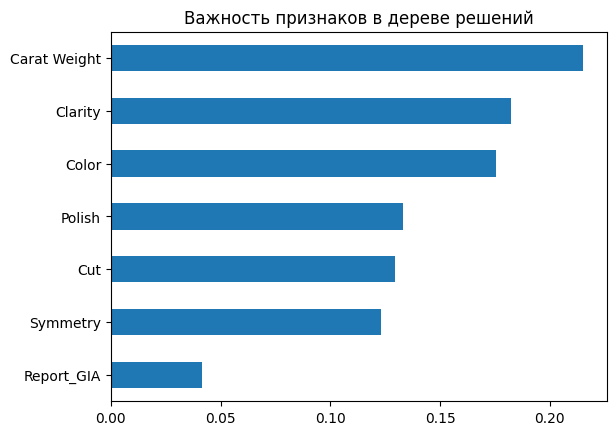

In [36]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

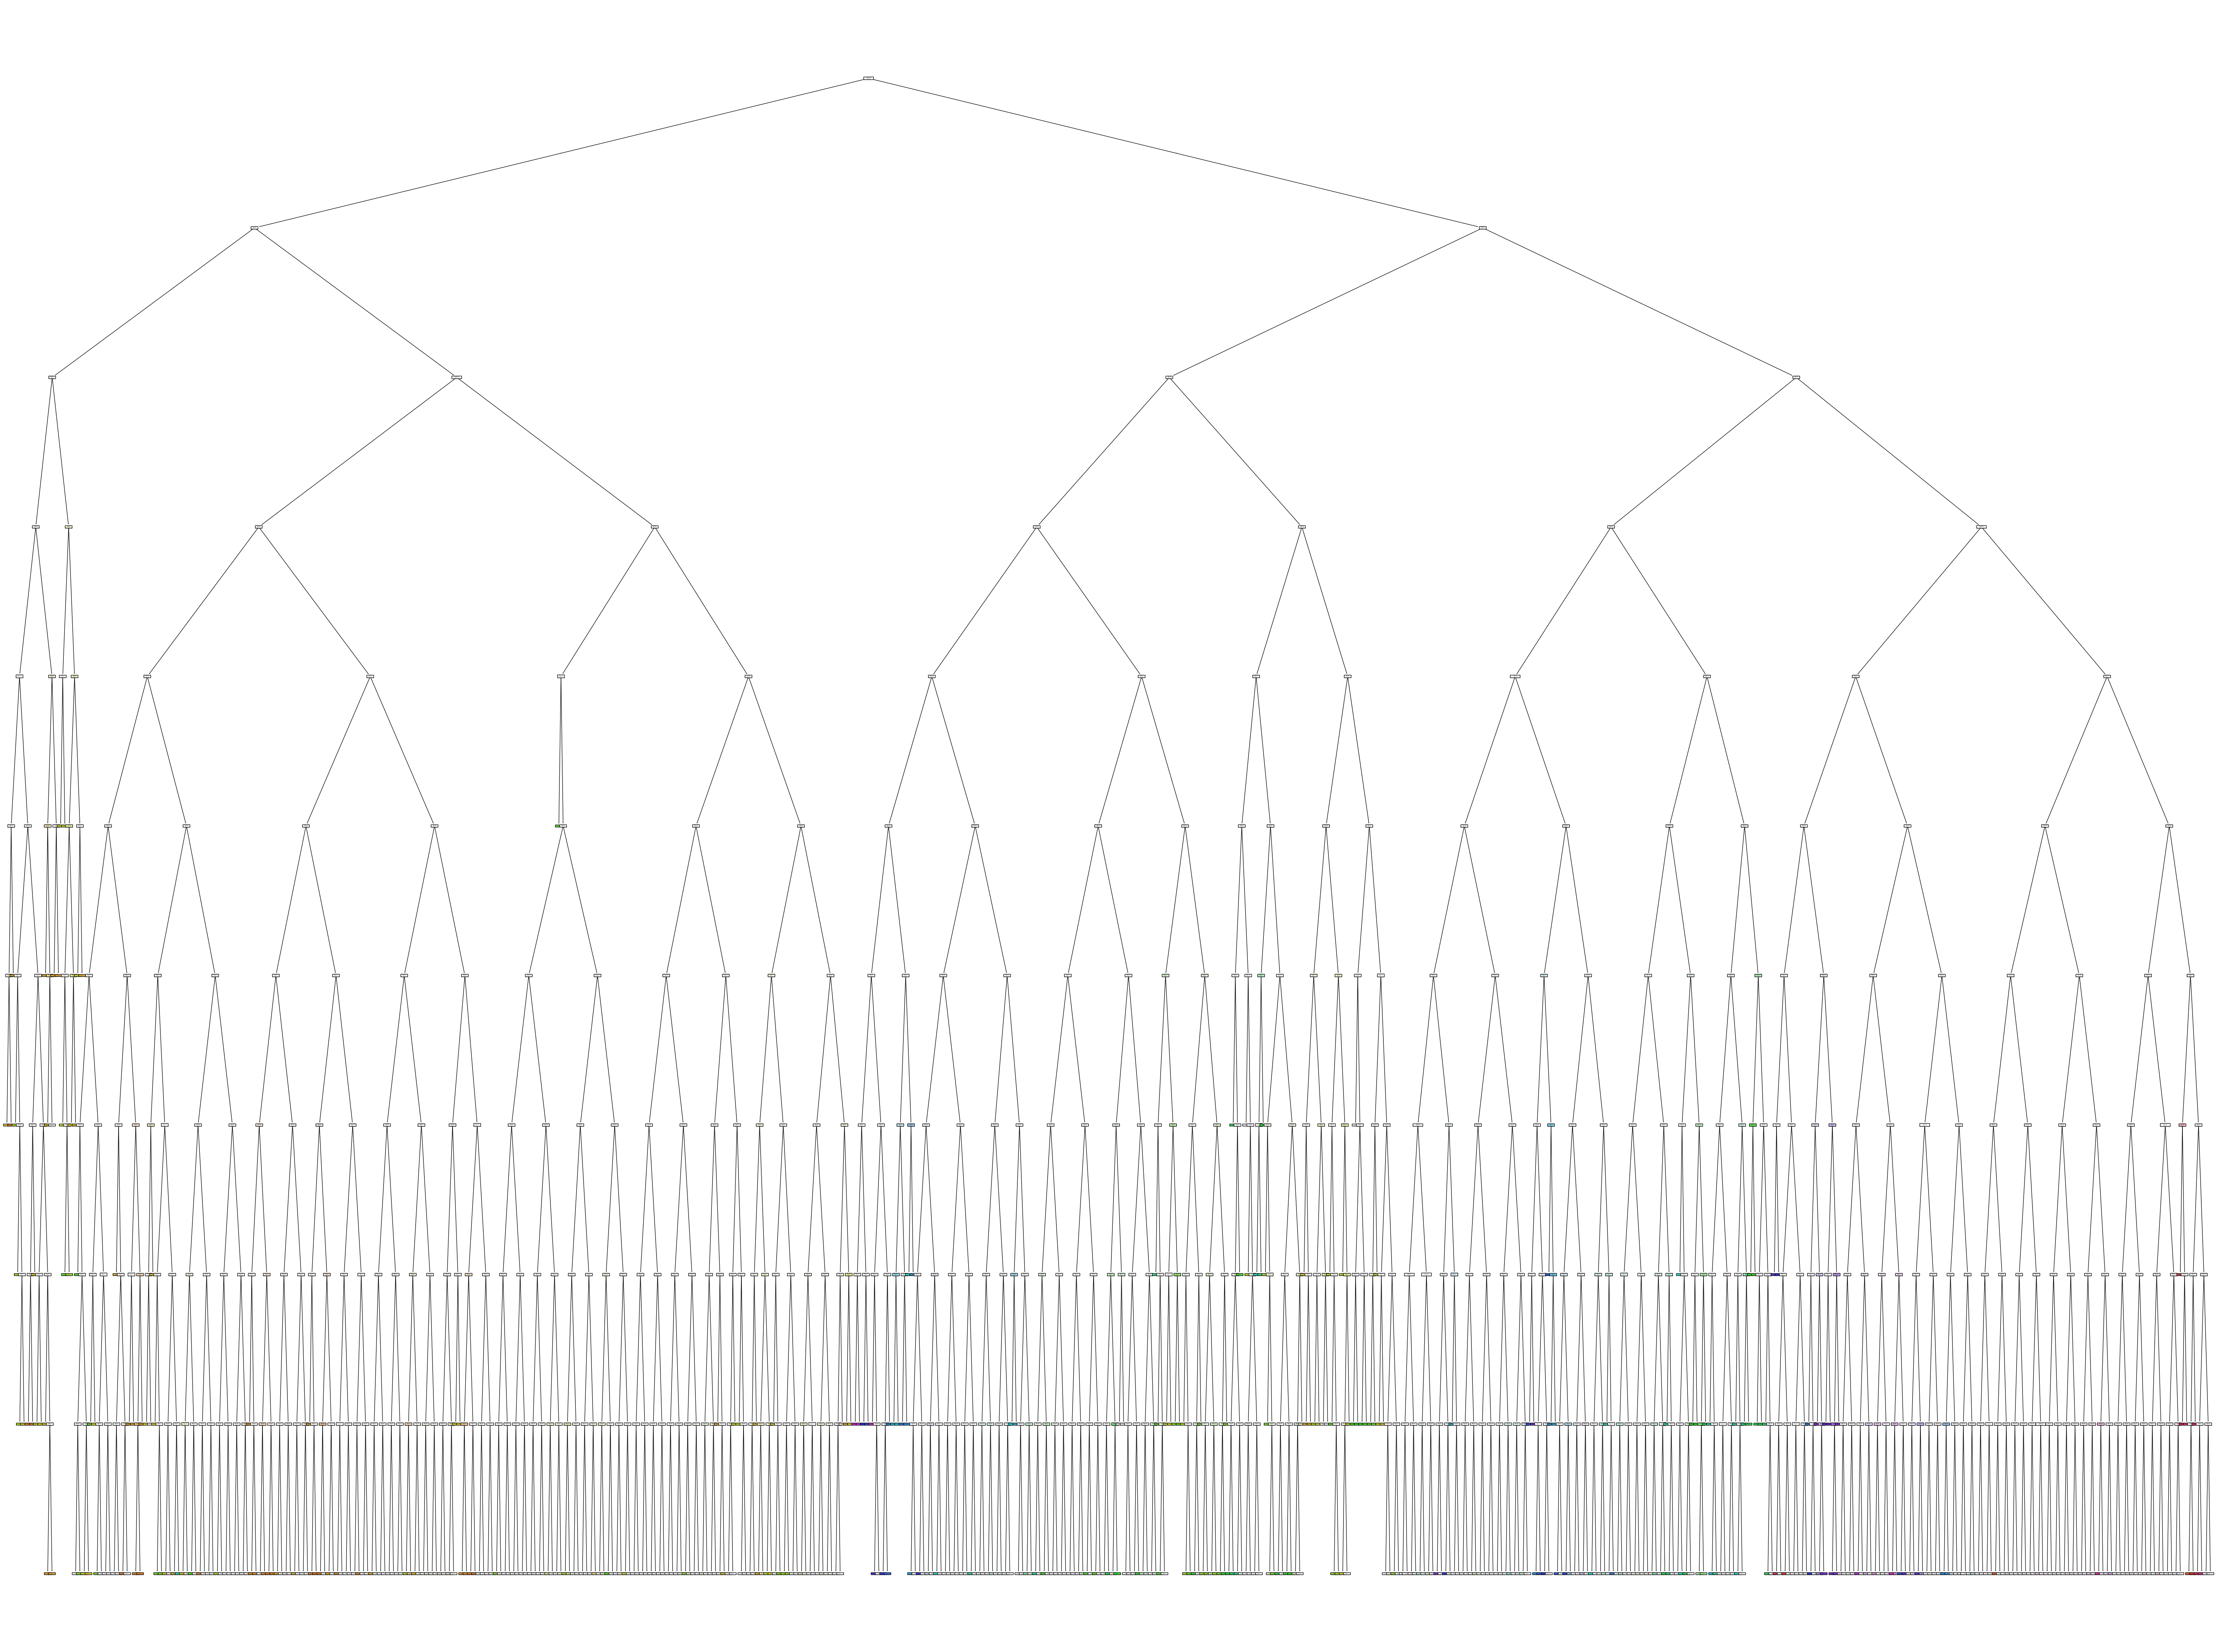

In [37]:
from sklearn.tree import plot_tree
# визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()